<a href="https://colab.research.google.com/github/sangjun315/FedAvg-Pytorch/blob/main/OneshotFL_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("pip, setuptools, wheel 업그레이드 중...")
    # pip, setuptools, wheel을 먼저 업그레이드합니다.
    !pip install --quiet --upgrade pip setuptools wheel

    # --- (수정) ---
    # Colab 기본 pandas(2.2.2) 버전과 충돌하지 않도록
    # scikit-learn만 업그레이드합니다.
    print("필요한 라이브러리 (scikit-learn) 업그레이드 중...")
    !pip install --quiet --upgrade scikit-learn
    # --- (수정 끝) ---

    print("\n[알림] 설치/업그레이드 완료. '셀 2'부터 실행을 계속하세요.")

except ImportError:
    print("Google Colab 환경이 아닙니다. 드라이브 마운트를 건너뜁니다.")


Mounted at /content/drive
pip, setuptools, wheel 업그레이드 중...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
필요한 라이브러리 (scikit-learn) 업그레이드 중...

[알림] 설치/업그레이드 완료. '셀 2'부터 실행을 계속하세요.


In [1]:
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')

except ImportError:
     print("Google Colab 환경이 아닙니다. 드라이브 마운트를 건너뜁니다.")

Mounted at /content/drive


In [2]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 2) 라이브러리 임포트 ---")

import os
import pickle
import numpy as np
import scipy.io
import scipy.sparse # Sparse matrix
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm # 진행률 표시

# Sent140 데이터 다운로드용
import urllib.request
import zipfile

# Scikit-learn (논문의 SVM, AUC, 전처리용)
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

print("라이브러리 임포트 완료.")


--- (셀 2) 라이브러리 임포트 ---
라이브러리 임포트 완료.


In [3]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 3) 경로 및 파라미터 설정 ---")

# --- 기본 경로 ---
BASE_DRIVE_PATH = '/content/drive/My Drive/oneshot/'
DATA_PATH = BASE_DRIVE_PATH
RESULTS_PATH = os.path.join(BASE_DRIVE_PATH, 'results')

# --- Sent140 데이터 경로 ---
SENT140_ZIP_PATH = os.path.join(DATA_PATH, 'trainingandtestdata.zip')
SENT140_CSV_PATH = os.path.join(DATA_PATH, 'training.1600000.processed.noemoticon.csv')


# 결과 저장 폴더 생성
os.makedirs(RESULTS_PATH, exist_ok=True)
print(f"데이터 경로: {DATA_PATH}")
print(f"결과 저장 경로: {RESULTS_PATH}")

# 논문에서 주어진 파라미터
DATASET_PARAMS = {
    'emnist': {'cv': 10, 'data': 100, 'random': 50},
    'sent140': {'cv': 10, 'data': 10, 'random': 50},
    'gleam': {'cv': 10, 'data': 10, 'random': 10},
}
# 논문의 최소 샘플 수 (Section 4)
MIN_SAMPLES_THRESHOLD = {
    'emnist': 60,
    'sent140': 30,
    'gleam': 30
}

# Distillation(증류) 실험용 프록시 샘플 크기 (Figure 3)
PROXY_SAMPLE_SIZES = {
    'emnist': list(range(10, 1501, 50)),
    'sent140': list(range(10, 1501, 50)),
    'gleam': list(range(5, 201, 10))
}

print("경로 및 파라미터 설정 완료.")


--- (셀 3) 경로 및 파라미터 설정 ---
데이터 경로: /content/drive/My Drive/oneshot/
결과 저장 경로: /content/drive/My Drive/oneshot/results
경로 및 파라미터 설정 완료.


In [8]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 4) 데이터 로드 함수 정의 ---")

def load_emnist_data():
    """
    EMNIST .mat 파일 로드 및 전처리.
    반환: { client_id: (X_scaled, y, None) }
    """
    mat_path = os.path.join(DATA_PATH, 'emnist-letters.mat')
    print(f"EMNIST 데이터 로드 중: {mat_path}")
    try:
        mat = scipy.io.loadmat(mat_path)
        data = mat['dataset'][0][0]
        train_images = data['train'][0][0]['images']
        train_labels = data['train'][0][0]['labels'].squeeze()
        train_writers = data['train'][0][0]['writers'].squeeze()
        test_images = data['test'][0][0]['images']
        test_labels = data['test'][0][0]['labels'].squeeze()
        test_writers = data['test'][0][0]['writers'].squeeze()

        all_images = np.concatenate((train_images, test_images))
        all_labels = np.concatenate((train_labels, test_labels))
        all_writers = np.concatenate((train_writers, test_writers))

        all_images_scaled = all_images.reshape(-1, 28 * 28) / 255.0 # 이미 0~1 스케일링됨
        all_labels_binary = np.where(all_labels <= 13, 0, 1)
        print(f"총 이미지: {len(all_images_scaled)}, 총 레이블: {len(all_labels_binary)}, 총 writer: {len(np.unique(all_writers))}")

        client_data = {}
        unique_writers = np.unique(all_writers)
        for writer_id in unique_writers:
            indices = np.where(all_writers == writer_id)[0]
            if not indices.size: continue
            writer_images = all_images_scaled[indices]
            writer_labels = all_labels_binary[indices]
            # 스케일러 불필요 (None)
            client_data[str(writer_id)] = (writer_images, writer_labels, None)

        print(f"EMNIST: {len(client_data)}개의 클라이언트(writer) 데이터 생성 완료.")
        return client_data
    except FileNotFoundError: print(f"파일을 찾을 수 없습니다: {mat_path}"); return None
    except Exception as e: print(f"EMNIST 데이터 로드 오류: {e}"); return None

def load_sent140_data():
    """
    Sent140 CSV 로드 및 Tfidf 전처리. Tfidf는 스케일링 불필요.
    반환: { client_id: (X_tfidf, y, None) }
    """
    print("Sent140 데이터 로드 중 (Pandas 사용)...")
    try:
        if not os.path.exists(SENT140_CSV_PATH):
            print(f"CSV 파일({os.path.basename(SENT140_CSV_PATH)}) 없음.")
            if not os.path.exists(SENT140_ZIP_PATH):
                print(f"오류: {SENT140_ZIP_PATH} 파일을 찾을 수 없습니다.")
                print(f"구글 드라이브 '{DATA_PATH}' 폴더에 'trainingandtestdata.zip' 파일을 직접 업로드해주세요.")
                return None
            print(f"압축 해제 중: {SENT140_ZIP_PATH}")
            with zipfile.ZipFile(SENT140_ZIP_PATH, 'r') as zip_ref:
                zip_ref.extract(os.path.basename(SENT140_CSV_PATH), path=DATA_PATH)
            print("압축 해제 완료.")

        print(f"CSV 로드 중: {SENT140_CSV_PATH}")
        col_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']
        df = pd.read_csv( SENT140_CSV_PATH, encoding='latin-1', header=None, names=col_names )

        print("Sent140: TfidfVectorizer 학습 중 (모든 트윗 대상)...")
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        vectorizer.fit(df['text'].values)

        print("Sent140: 클라이언트(user)별 데이터 변환 중...")
        client_data = {}
        grouped = df.groupby('user')
        for user_id, group_df in tqdm(grouped):
            X_client_text = group_df['text'].values
            y_client = np.where(group_df['sentiment'].values == 4, 1, 0)
            if not y_client.size: continue
            X_client_tfidf = vectorizer.transform(X_client_text)
            # 스케일러 불필요 (None)
            client_data[user_id] = (X_client_tfidf, y_client, None)

        print(f"Sent140: {len(client_data)}개의 클라이언트 데이터 생성 완료.")
        return client_data
    except Exception as e: print(f"Sent140 데이터 로드 오류: {e}"); return None

# --- (GLEAM 로더 함수들) ---
def _get_gleam_eat_intervals(annotate_df):
    intervals = []
    start_time = None
    if not {'Activity', 'Status', 'Time'}.issubset(annotate_df.columns):
        raise ValueError(f"Annotate file missing required columns (Time, Activity, Status). Found: {list(annotate_df.columns)}")
    # 'eat' 및 'eating' 모두 포함하도록 수정
    eat_events = annotate_df[annotate_df['Activity'].str.contains('eat', case=False, na=False)]
    for _, row in eat_events.iterrows():
        status = str(row['Status']).strip().replace('"', '')
        time = row['Time']
        if status == 'start': start_time = time
        elif status == 'stop' and start_time is not None:
            intervals.append((start_time, time)); start_time = None
    return intervals

def _label_gleam_sensor_data(sensor_df, intervals):
    def label_func(timestamp):
        for start, end in intervals:
            if start <= timestamp <= end: return 1
        return 0
    sensor_df['label'] = sensor_df['Unix Time'].apply(label_func)
    return sensor_df

def _create_gleam_features(accel_df):
    WINDOW_SIZE = 50; STEP_SIZE = 25 # 1초 윈도우, 50% 겹침
    features = []; labels = []
    for i in range(0, len(accel_df) - WINDOW_SIZE + 1, STEP_SIZE):
        window = accel_df.iloc[i : i + WINDOW_SIZE]
        # NaN 값 포함될 수 있으므로 mean, std 계산 시 numeric_only 고려
        current_features = []
        for col in ['Value1', 'Value2', 'Value3']:
             # mean, std 외 추가 피처 (min, max, median, var)
            stats = window[col].agg(['mean', 'std', 'min', 'max', 'median', 'var'])
            current_features.extend(stats.tolist())
        features.append(current_features)
        mode_result = window['label'].mode()
        # mode() 결과가 비었거나 window 자체가 비었을 경우 대비
        if not mode_result.empty:
            labels.append(mode_result[0])
        elif not window.empty:
            # mode가 없으면 첫 번째 레이블 사용 (임시 방편)
            labels.append(window['label'].iloc[0])
        # else: # window가 비었으면 아무것도 추가 안 함 (길이 불일치 방지)

    if not features or len(features) != len(labels):
        # print(f"Feature/Label length mismatch: {len(features)} vs {len(labels)}") # 디버깅
        return None, None
    # 생성된 피처의 NaN/Inf 처리 후 반환
    X_client = pd.DataFrame(features).fillna(0).values
    y_client = np.array(labels)
    return X_client, y_client

def load_gleam_data():
    """
    GLEAM 데이터 로드 (타임스탬프 매칭).
    반환: { client_id: (X_unscaled, y, scaler) }
    """
    gleam_path = os.path.join(DATA_PATH, 'GLEAM')
    print(f"GLEAM 데이터 로드 중 (New Logic, returns unscaled data + scaler): {gleam_path}")
    client_folders = [f.path for f in os.scandir(gleam_path) if f.is_dir() and f.name.isdigit()]
    client_data = {}
    print(f"GLEAM: {len(client_folders)}개의 클라이언트 폴더 처리 중...")

    for client_path in tqdm(client_folders, desc="Processing GLEAM clients"):
        client_id = os.path.basename(client_path)
        try:
            annotate_file = glob(os.path.join(client_path, f'{client_id}_annotate.*'))
            if not annotate_file:
                # print(f"Warning: Client {client_id} missing annotate file. Skipping.")
                continue
            # header=None, names=... 로 컬럼명 지정, quote 처리 강화
            annotate_df = pd.read_csv(annotate_file[0], header=None, names=['Time', 'Activity', 'Status'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
            annotate_df[['Activity', 'Status']] = annotate_df[['Activity', 'Status']].astype(str).apply(lambda x: x.str.strip().str.replace('"', ''))
            annotate_df['Time'] = pd.to_numeric(annotate_df['Time'], errors='coerce')
            annotate_df = annotate_df.dropna(subset=['Time', 'Activity', 'Status'])
            if annotate_df.empty:
                # print(f"Warning: Client {client_id} annotate file empty after cleaning. Skipping.")
                continue
            eat_intervals = _get_gleam_eat_intervals(annotate_df)
            if not eat_intervals:
                # print(f"Warning: Client {client_id} has no 'eat' intervals. Skipping.")
                continue

            sensor_file = glob(os.path.join(client_path, f'{client_id}_sensor*'))
            # ._ 파일 제외
            sensor_file = [f for f in sensor_file if 'annotate' not in f.lower() and not os.path.basename(f).startswith('._')]
            if not sensor_file:
                # print(f"Warning: Client {client_id} missing sensor file. Skipping.")
                continue
            # header=None, names=... 로 컬럼명 지정, quote 처리 강화
            sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
            sensor_df['Sensor'] = sensor_df['Sensor'].astype(str).str.strip().str.replace('"', '')
            if not {'Sensor', 'Unix Time'}.issubset(sensor_df.columns):
                # print(f"Warning: Client {client_id} sensor file missing columns. Skipping.")
                continue
            accel_df = sensor_df[sensor_df['Sensor'].str.contains('Accel', case=False, na=False)].copy()
            if accel_df.empty:
                # print(f"Warning: Client {client_id} has no Accelerator data. Skipping.")
                continue
            for col in ['Value1', 'Value2', 'Value3', 'Unix Time']:
                accel_df[col] = pd.to_numeric(accel_df[col], errors='coerce')
            accel_df = accel_df.dropna(subset=['Value1', 'Value2', 'Value3', 'Unix Time']).sort_values(by='Unix Time')
            if accel_df.empty:
                # print(f"Warning: Client {client_id} accel data empty after cleaning. Skipping.")
                continue

            accel_df_labeled = _label_gleam_sensor_data(accel_df.reset_index(drop=True), eat_intervals)
            X_client_unscaled, y_client = _create_gleam_features(accel_df_labeled)

            if X_client_unscaled is None or X_client_unscaled.shape[0] == 0 or len(np.unique(y_client)) < 2:
                # print(f"Warning: Client {client_id} failed feature creation or has only one class. Skipping.")
                continue

            # NaN/Inf 값 처리 후 스케일러 학습 (여기서는 처리만 하고 스케일러 fit은 transform 전에)
            if np.any(np.isnan(X_client_unscaled)) or np.any(np.isinf(X_client_unscaled)):
                 # print(f"Warning: NaN/Inf found in client {client_id} features. Replacing with 0.")
                 X_client_unscaled = np.nan_to_num(X_client_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                 # NaN 처리 후에도 데이터가 남아있는지 확인
                 if X_client_unscaled.shape[0] == 0: continue

            # fit_transform 대신 fit만 수행
            scaler = StandardScaler().fit(X_client_unscaled)
            client_data[client_id] = (X_client_unscaled, y_client, scaler)

        except Exception as e:
            # print(f"GLEAM Client {client_id} 처리 오류: {e}") # 디버깅 시 주석 해제
            # traceback.print_exc()
            continue

    print(f"GLEAM: {len(client_data)}개의 클라이언트 데이터 생성 완료.")
    return client_data
# --- (GLEAM 로더 수정 끝) ---

# 데이터 로더 맵
DATA_LOADERS = {
    'emnist': load_emnist_data,
    'sent140': load_sent140_data,
    'gleam': load_gleam_data,
}
print("데이터 로드 함수 정의 완료.")

--- (셀 4) 데이터 로드 함수 정의 ---
데이터 로드 함수 정의 완료.


In [9]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 5) 핵심 실험 함수 정의 ---")

def predict_ensemble(ensemble_models, X_input):
    """앙상블 모델 예측 (입력 X는 스케일링 필요 여부 확인)"""
    if not ensemble_models: return np.full(X_input.shape[0], 0.5)
    all_preds = []

    n_features = -1
    # 첫 번째 모델에서 피처 수 확인 (더 안정적인 방법)
    if ensemble_models:
        first_model = ensemble_models[0]
        if hasattr(first_model, 'n_features_in_') and first_model.n_features_in_ is not None:
            n_features = first_model.n_features_in_
        elif hasattr(first_model, 'support_vectors_') and hasattr(first_model.support_vectors_, 'shape'):
            n_features = first_model.support_vectors_.shape[1]

    if X_input is None or X_input.shape[0] == 0: return np.array([])
    # 차원 불일치 시에도 기본 예측 반환 (오류 방지)
    if n_features != -1 and hasattr(X_input, 'shape') and X_input.ndim == 2 and X_input.shape[1] != n_features:
        # print(f"Warning: Ensemble feature mismatch. Expected {n_features}, got {X_input.shape[1]}")
        return np.full(X_input.shape[0], 0.5)

    for model in ensemble_models:
        try:
             model_n_features = -1
             if hasattr(model, 'n_features_in_') and model.n_features_in_ is not None: model_n_features = model.n_features_in_
             elif hasattr(model, 'support_vectors_') and hasattr(model.support_vectors_, 'shape'): model_n_features = model.support_vectors_.shape[1]

             # n_features가 결정되었고 모델의 피처 수가 다르면 스킵
             if n_features != -1 and model_n_features != n_features:
                 all_preds.append(np.full(X_input.shape[0], 0.5))
                 continue

             # predict_proba 호출 전 입력 데이터 확인
             if X_input is None or X_input.shape[0] == 0: continue

             # Sparse matrix 및 NaN/Inf 처리된 데이터는 바로 사용
             if isinstance(X_input, scipy.sparse.csr_matrix) or not np.isnan(X_input).any():
                pred = model.predict_proba(X_input)[:, 1]
                all_preds.append(pred)
             else: # NaN/Inf 포함 시 0.5 예측
                all_preds.append(np.full(X_input.shape[0], 0.5))

        except Exception as e:
            # print(f"Predict proba error: {e}") # 디버깅
            all_preds.append(np.full(X_input.shape[0], 0.5))

    if not all_preds: return np.full(X_input.shape[0], 0.5)

    # NaN 값 방지 후 평균 계산
    valid_preds = [p for p in all_preds if p is not None and not np.isnan(p).any()]
    if not valid_preds: return np.full(X_input.shape[0], 0.5)
    return np.mean(valid_preds, axis=0)

# 기존 evaluate_model 함수 정의를 아래 코드로 교체하세요.

def evaluate_model(model_or_ensemble, device_eval_info, scaler_type='local', global_scaler_obj=None, print_client_scores_for_ensemble=False, dataset_name_for_print=""):
    """ 모델 평가. scaler_type에 따라 스케일러 적용. print_client_scores_for_ensemble=True 시 앙상블의 개별 클라이언트 점수 출력 """
    all_device_aucs = []
    is_ensemble = isinstance(model_or_ensemble, list)

    # --- (추가) ---
    # Full Ensemble 식별 (Sent140 조건 추가 - scaler_type이 'none'인 경우)
    # 조금 더 정확하게 하려면 run_experiment 에서 Full Ensemble 평가 시 print_client_scores_for_ensemble=True 로 넘겨주는 것이 좋습니다.
    # 여기서는 scaler_type과 is_ensemble 조건으로 간략히 추정합니다.
    is_likely_sent140_full_ensemble = is_ensemble and scaler_type == 'none' and dataset_name_for_print == 'sent140'
    if is_likely_sent140_full_ensemble and print_client_scores_for_ensemble:
        print(f"\n--- [{dataset_name_for_print}] Full Ensemble 개별 클라이언트 AUC 점수 ---")
    # --- (추가 끝) ---

    expected_features_ensemble = -1
    if is_ensemble and model_or_ensemble:
        first_model = model_or_ensemble[0]
        if hasattr(first_model, 'n_features_in_') and first_model.n_features_in_ is not None: expected_features_ensemble = first_model.n_features_in_
        elif hasattr(first_model, 'support_vectors_') and hasattr(first_model.support_vectors_, 'shape'): expected_features_ensemble = first_model.support_vectors_.shape[1]

    for client_id, (X_unscaled, y_test, local_scaler) in device_eval_info.items():
        if X_unscaled is None or X_unscaled.shape[0] == 0 or len(np.unique(y_test)) < 2: continue

        auc = 0.5 # 기본값 설정

        try:
            scaler_to_use = None
            if scaler_type == 'global': scaler_to_use = global_scaler_obj
            elif scaler_type == 'local': scaler_to_use = local_scaler

            X_scaled = X_unscaled
            if scaler_to_use:
                try:
                    if X_unscaled.ndim == 1: X_unscaled = X_unscaled.reshape(1, -1)
                    X_unscaled_clean = np.nan_to_num(X_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                    if X_unscaled_clean.shape[0] > 0: X_scaled = scaler_to_use.transform(X_unscaled_clean)
                    else: continue
                except Exception as scale_e: continue
            elif scaler_type == 'none':
                 if isinstance(X_unscaled, scipy.sparse.csr_matrix):
                     X_scaled = X_unscaled
                 else:
                    X_scaled = np.nan_to_num(X_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                 if X_scaled.shape[0] == 0: continue

            if X_scaled.shape[0] == 0: continue

            y_pred_proba = None # 예측 확률 초기화
            if is_ensemble:
                 if expected_features_ensemble != -1 and X_scaled.shape[1] != expected_features_ensemble: continue
                 y_pred_proba = predict_ensemble(model_or_ensemble, X_scaled)
                 if not hasattr(y_pred_proba, 'shape') or y_pred_proba.shape[0] == 0: continue
            else: # 단일 모델
                expected_features = -1
                if hasattr(model_or_ensemble, 'n_features_in_') and model_or_ensemble.n_features_in_ is not None: expected_features = model_or_ensemble.n_features_in_
                elif hasattr(model_or_ensemble, 'support_vectors_') and hasattr(model_or_ensemble.support_vectors_, 'shape'): expected_features = model_or_ensemble.support_vectors_.shape[1]
                is_svr = isinstance(model_or_ensemble, SVR)

                if expected_features != -1 and X_scaled.shape[1] != expected_features: continue

                if is_svr: y_pred_proba = model_or_ensemble.predict(X_scaled)
                else: y_pred_proba = model_or_ensemble.predict_proba(X_scaled)[:, 1]
                if not hasattr(y_pred_proba, 'shape') or y_pred_proba.shape[0] == 0: continue

            # NaN 처리 강화 및 AUC 계산
            if y_pred_proba is not None: # 예측값이 생성된 경우에만 AUC 계산
                if np.isnan(y_pred_proba).any():
                    auc = 0.5 # NaN 예측 시 0.5
                else:
                    y_pred_proba = np.clip(y_pred_proba, 0, 1)
                    try:
                        auc = roc_auc_score(y_test, y_pred_proba)
                    except ValueError as ve: # roc_auc_score 오류 (예: 한 클래스만 예측) 시 0.5 처리
                        auc = 0.5
            else:
                 auc = 0.5 # 예측값 생성 실패 시 0.5

            # --- (추가) ---
            # 특정 조건(Sent140 Full Ensemble)일 때 클라이언트별 AUC 출력
            if is_likely_sent140_full_ensemble and print_client_scores_for_ensemble:
                print(f"Client {client_id}: AUC = {auc:.4f}")
            # --- (추가 끝) ---

            all_device_aucs.append(auc)

        except Exception as e:
            # 기타 예외 발생 시 0.5 처리
            # print(f"Error evaluating client {client_id}: {e}") # 디버깅 필요시 주석 해제
            # --- (추가) ---
            # 에러 발생 시에도 AUC 출력 (디버깅용)
            if is_likely_sent140_full_ensemble and print_client_scores_for_ensemble:
                 print(f"Client {client_id}: AUC = 0.5 (Error: {e})")
            # --- (추가 끝) ---
            all_device_aucs.append(0.5)

    valid_aucs = [auc for auc in all_device_aucs if not np.isnan(auc)]
    return np.mean(valid_aucs) if valid_aucs else 0.5

# --- run_experiment 함수 내 Full Ensemble 평가 부분 수정 ---
# 기존 run_experiment 함수 정의 셀에서 아래 부분을 찾아서 수정하세요.
# (대략 120번째 줄 근처)

    print(f"[{dataset_name}] 3/5: 앙상블 선택 및 평가 중...")
    eligible_clients = list(device_models.keys()); eligible_scores = device_scores; eligible_models = device_models
    # --- (수정) ---
    # GLEAM은 'local', 나머지는 'none' (Sent140 포함)
    eval_scaler_type = 'local' if dataset_name == 'gleam' else 'none'
    # --- (수정 끝) ---

    full_ensemble_models = list(eligible_models.values())
    # --- (수정) ---
    # Full Ensemble 평가 시 클라이언트 점수 출력을 위한 파라미터 추가
    full_ensemble_auc = evaluate_model(
        full_ensemble_models,
        device_eval_info,
        scaler_type=eval_scaler_type,
        print_client_scores_for_ensemble=True, # 이 플래그를 True로 설정
        dataset_name_for_print=dataset_name     # 데이터셋 이름 전달
    )
    # --- (수정 끝) ---

    # (이하 CV, Data, Random 앙상블 평가 코드는 그대로 둡니다)
    # ... (생략) ...


def run_experiment(dataset_name, client_data):
    """ 논문의 전체 실험 파이프라인 (Fig 2/3 Teacher 동적 선택, Ideal C=10, Sent140 Local C=5.0) """
    print(f"--- [{dataset_name}] 실험 시작 ---")
    if not client_data: print(f"[{dataset_name}] 데이터가 없어 실험을 건너뜁니다."); return None

    PARAMS = DATASET_PARAMS[dataset_name]
    MIN_SAMPLES = MIN_SAMPLES_THRESHOLD[dataset_name]

    device_models = {}; device_scores = {}
    device_eval_info = {} # 이제 (X_unscaled, y, local_scaler) 저장
    device_local_baseline_scores = {} # 각 로컬 모델을 *자신의* 테스트셋에서 평가한 점수 저장
    all_X_train_unscaled, all_y_train = [], []
    all_X_val_unscaled, all_y_val = [], []

    print(f"[{dataset_name}] 1/5: 로컬 모델 학습 중...")

    for client_id, (X_unscaled, y, local_scaler) in tqdm(client_data.items()):

        # 데이터 유효성 검사 강화
        if X_unscaled is None or not hasattr(X_unscaled, 'shape') \
           or (not isinstance(X_unscaled, scipy.sparse.csr_matrix) and X_unscaled.ndim != 2) \
           or X_unscaled.shape[0] < MIN_SAMPLES or len(np.unique(y)) < 2:
            continue # 조건 불충족 시 건너뜀
        try:
            # Train/Test/Val 분할 (스케일링 전 데이터 기준)
            X_train_unscaled, X_rem_unscaled, y_train, y_rem = train_test_split(X_unscaled, y, test_size=0.5, random_state=42, stratify=y)
            X_test_unscaled, X_val_unscaled, y_test, y_val = train_test_split(X_rem_unscaled, y_rem, test_size=0.2, random_state=42, stratify=y_rem)
        except ValueError: continue # Stratify 실패 시 건너뜀

        X_train, X_test, X_val = X_train_unscaled, X_test_unscaled, X_val_unscaled
        is_already_scaled = local_scaler is None # EMNIST, Sent140은 True

        # GLEAM 데이터만 로컬 스케일링 적용
        if not is_already_scaled:
            try:
                X_train_unscaled_clean = np.nan_to_num(X_train_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                X_test_unscaled_clean = np.nan_to_num(X_test_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                X_val_unscaled_clean = np.nan_to_num(X_val_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                if X_train_unscaled_clean.shape[0] > 0: X_train = local_scaler.transform(X_train_unscaled_clean)
                else: X_train = np.array([]).reshape(0, X_train_unscaled.shape[1] if X_train_unscaled.ndim > 1 else 0)
                if X_test_unscaled_clean.shape[0] > 0: X_test = local_scaler.transform(X_test_unscaled_clean)
                else: X_test = np.array([]).reshape(0, X_test_unscaled.shape[1] if X_test_unscaled.ndim > 1 else 0)
                if X_val_unscaled_clean.shape[0] > 0: X_val = local_scaler.transform(X_val_unscaled_clean)
                else: X_val = np.array([]).reshape(0, X_val_unscaled.shape[1] if X_val_unscaled.ndim > 1 else 0)
            except Exception as e: continue

        if X_train.shape[0] == 0: continue

        # --- (수정) ---
        # 로컬 모델 하이퍼파라미터 설정 (Sent140만 C=5.0)
        local_C = 7.5 if dataset_name == 'sent140' else 1.0
        model = SVC(kernel='rbf', probability=True, C=local_C, gamma='scale', class_weight='balanced', random_state=42)
        # --- (수정 끝) ---
        try:
            # Sparse matrix는 NaN 체크 불필요
            if not isinstance(X_train, scipy.sparse.csr_matrix) and (np.isnan(X_train).any() or np.isinf(X_train).any()):
                continue
            model.fit(X_train, y_train)
        except Exception as e: continue

        val_auc = 0.5
        if X_val.shape[0] > 0 and len(np.unique(y_val)) >= 2:
            try:
                pred_proba_val = model.predict_proba(X_val)[:, 1]
                if not np.isnan(pred_proba_val).any(): val_auc = roc_auc_score(y_val, np.clip(pred_proba_val, 0, 1))
            except: pass

        test_auc = 0.5 # 로컬 테스트셋 점수 계산 (Local Baseline 용)
        if X_test.shape[0] > 0 and len(np.unique(y_test)) >= 2:
             try:
                 pred_proba_test = model.predict_proba(X_test)[:, 1]
                 if not np.isnan(pred_proba_test).any():
                     test_auc = roc_auc_score(y_test, np.clip(pred_proba_test, 0, 1))
             except: pass

        device_models[client_id] = model
        device_scores[client_id] = val_auc
        device_eval_info[client_id] = (X_test_unscaled, y_test, local_scaler)
        device_local_baseline_scores[client_id] = test_auc # 로컬 점수 저장

        all_X_train_unscaled.append(X_train_unscaled)
        all_y_train.append(y_train)
        all_X_val_unscaled.append(X_val_unscaled)
        all_y_val.append(y_val)

    if not device_models: print(f"[{dataset_name}] 학습 가능한 클라이언트 없음"); return None

    print(f"[{dataset_name}] 2/5: 'Unachievable Ideal' 모델 학습 중...")
    global_scaler = None; ideal_auc = 0.5
    if all_X_train_unscaled:
        # 데이터셋이 스케일링 필요한지 확인 (client_data 구조 변경됨)
        # 첫 번째 유효한 클라이언트 찾기
        first_valid_client_id = next((cid for cid in client_data if client_data[cid] is not None), None)
        needs_global_scaling = False
        if first_valid_client_id and client_data[first_valid_client_id][2] is not None:
             needs_global_scaling = True

        is_sparse = isinstance(all_X_train_unscaled[0], scipy.sparse.csr_matrix)
        X_ideal_unscaled = None
        temp_X_list = [x for x in all_X_train_unscaled if x is not None and (isinstance(x, scipy.sparse.csr_matrix) or (hasattr(x, 'shape') and x.shape[0] > 0))]
        if not temp_X_list: print(f"[{dataset_name}] Ideal model: 유효한 학습 데이터 없음.")
        elif is_sparse:
            X_ideal_unscaled = scipy.sparse.vstack(temp_X_list)
            print(f"[{dataset_name}] Ideal model: Sparse 데이터 사용, 전역 스케일링 건너뜀.")
            needs_global_scaling = False
        else:
            try:
                temp_X = np.vstack(temp_X_list)
                if np.any(np.isnan(temp_X)) or np.any(np.isinf(temp_X)):
                     print("Warning: Ideal 학습 데이터에 NaN/Inf 발견. 0으로 대체.")
                     temp_X = np.nan_to_num(temp_X, nan=0.0, posinf=0.0, neginf=0.0)
                if temp_X.shape[0] > 0:
                     X_ideal_unscaled = temp_X
                     if needs_global_scaling:
                         try:
                             global_scaler = StandardScaler().fit(X_ideal_unscaled)
                             print(f"[{dataset_name}] Ideal model: 전역 스케일러 학습 완료.")
                         except Exception as e: print(f"Warning: 전역 스케일러 학습 실패: {e}. 스케일러 없음."); global_scaler = None
                else: print(f"[{dataset_name}] Ideal model: 필터링 후 유효한 학습 데이터 없음.")
            except ValueError as ve: print(f"Error stacking Ideal training data: {ve}"); X_ideal_unscaled = None

        if X_ideal_unscaled is not None and X_ideal_unscaled.shape[0] > 0:
            X_ideal_scaled = X_ideal_unscaled
            if global_scaler:
                try: X_ideal_scaled = global_scaler.transform(X_ideal_unscaled)
                except Exception as e: print(f"Warning: Ideal 데이터 전역 변환 실패: {e}. 스케일링 안 된 데이터 사용."); X_ideal_scaled = X_ideal_unscaled; global_scaler = None
            valid_y_train_list = [y for y, x in zip(all_y_train, all_X_train_unscaled) if x is not None and (isinstance(x, scipy.sparse.csr_matrix) or (hasattr(x, 'shape') and x.shape[0] > 0))]
            if valid_y_train_list:
                y_ideal = np.concatenate(valid_y_train_list)
                if X_ideal_scaled.shape[0] == y_ideal.shape[0]:
                    # Ideal 모델: C=10
                    ideal_model = SVC(kernel='rbf', probability=True, C=10, gamma='scale', class_weight='balanced', random_state=42)
                    try:
                        ideal_model.fit(X_ideal_scaled, y_ideal)
                        ideal_scaler_type = 'global' if global_scaler else 'none'
                        ideal_auc = evaluate_model(ideal_model, device_eval_info, scaler_type=ideal_scaler_type, global_scaler_obj=global_scaler)
                    except Exception as fit_e: print(f"Ideal model 학습 오류: {fit_e}"); ideal_auc = 0.5
                else: print(f"Ideal model 데이터 길이 불일치: X={X_ideal_scaled.shape[0]}, y={y_ideal.shape[0]}"); ideal_auc = 0.5
            else: print("Ideal model: 유효한 레이블 없음."); ideal_auc = 0.5
        else: print("Ideal model: 학습 데이터 없음."); ideal_auc = 0.5

    print(f"[{dataset_name}] 3/5: 앙상블 선택 및 평가 중...")
    eligible_clients = list(device_models.keys()); eligible_scores = device_scores; eligible_models = device_models
    eval_scaler_type = 'local' if dataset_name == 'gleam' else 'none'

    full_ensemble_models = list(eligible_models.values())
    full_ensemble_auc = evaluate_model(full_ensemble_models, device_eval_info, scaler_type=eval_scaler_type)

    sorted_clients_cv = sorted(eligible_scores, key=eligible_scores.get, reverse=True)
    cv_clients = sorted_clients_cv[:PARAMS['cv']]
    cv_ensemble_models = [eligible_models[c] for c in cv_clients] if cv_clients else []
    cv_auc = evaluate_model(cv_ensemble_models, device_eval_info, scaler_type=eval_scaler_type)

    client_sizes = {cid: client_data[cid][1].shape[0] for cid in eligible_clients if cid in client_data and client_data[cid] and hasattr(client_data[cid][1], 'shape')}
    sorted_clients_data = sorted(client_sizes, key=client_sizes.get, reverse=True)
    data_clients = sorted_clients_data[:PARAMS['data']]
    data_ensemble_models = [eligible_models[c] for c in data_clients] if data_clients else []
    data_auc = evaluate_model(data_ensemble_models, device_eval_info, scaler_type=eval_scaler_type)

    random_aucs = []
    random_ensemble_models = [] # 마지막 앙상블 저장용
    if eligible_clients:
        num_to_select = min(PARAMS['random'], len(eligible_clients))
        if num_to_select > 0:
            for _ in range(5):
                random_clients = np.random.choice(eligible_clients, num_to_select, replace=False)
                current_random_ensemble = [eligible_models[c] for c in random_clients] if random_clients.size > 0 else []
                if current_random_ensemble: # 비어있지 않을 때만 평가 및 저장
                    random_aucs.append(evaluate_model(current_random_ensemble, device_eval_info, scaler_type=eval_scaler_type))
                    random_ensemble_models = current_random_ensemble # 마지막 앙상블 업데이트
                else:
                    random_aucs.append(0.5) # 비어있으면 0.5점

    valid_random_aucs = [auc for auc in random_aucs if not np.isnan(auc)]
    random_auc = np.mean(valid_random_aucs) if valid_random_aucs else 0.5

    # Local Baseline 계산: 원래 방식 (로컬 점수 평균)
    valid_local_scores = [s for s in device_local_baseline_scores.values() if not np.isnan(s)]
    local_auc = np.mean(valid_local_scores) if valid_local_scores else 0.5

    fig1_results = {
        'Unachievable Ideal': ideal_auc, 'Local': local_auc, 'Full Ensemble': full_ensemble_auc,
        f'CV, k={PARAMS["cv"]}': cv_auc, f'Data, k={PARAMS["data"]}': data_auc, f'Random, k={PARAMS["random"]}': random_auc
    }

    # --- (수정) ---
    # Figure 2/3 Teacher Ensemble 동적 선택 로직 (오류 수정)
    ensemble_results = { # 점수만 저장
        f'CV, k={PARAMS["cv"]}': cv_auc,
        f'Data, k={PARAMS["data"]}': data_auc,
        f'Random, k={PARAMS["random"]}': random_auc,
        'Full Ensemble': full_ensemble_auc
    }
    # NaN 값 제외하고 최고 성능 앙상블 찾기
    valid_ensemble_results = {k: v for k, v in ensemble_results.items() if not np.isnan(v)}
    best_ensemble_name = max(valid_ensemble_results, key=valid_ensemble_results.get) if valid_ensemble_results else 'Full Ensemble' # 기본값

    # 최고 성능 앙상블 모델 리스트 설정 (이름에 따라 올바른 변수 참조)
    fig2_ensemble = []
    if best_ensemble_name == 'Full Ensemble':
        fig2_ensemble = full_ensemble_models
    elif best_ensemble_name.startswith('CV'):
        fig2_ensemble = cv_ensemble_models
    elif best_ensemble_name.startswith('Data'):
        fig2_ensemble = data_ensemble_models
    elif best_ensemble_name.startswith('Random'):
        # Random은 평균 점수이므로, 마지막 랜덤 앙상블을 대표로 사용 (없으면 Full)
        fig2_ensemble = random_ensemble_models if random_ensemble_models else full_ensemble_models
    else: # 예외 처리: Full 사용
        fig2_ensemble = full_ensemble_models

    fig2_ensemble_name = best_ensemble_name # 이름은 최고 성능 이름 사용

    print(f"[{dataset_name}] Best ensemble for Fig 2/3: {fig2_ensemble_name} (AUC: {valid_ensemble_results.get(best_ensemble_name, 0.0):.3f})")
    # --- (수정 끝) ---

    # Figure 2 Ensemble 점수 계산 (선택된 최고 앙상블 사용)
    ensemble_scores_fig2 = [] # Fig2 Ensemble 점수 리스트
    for client_id, (X_test_unscaled, y_test, local_scaler) in device_eval_info.items():
        if len(np.unique(y_test)) < 2: continue
        try:
            X_test = X_test_unscaled
            current_scaler = local_scaler if eval_scaler_type == 'local' else None
            # 스케일링 적용 (필요 시)
            if current_scaler and X_test is not None and X_test.shape[0] > 0:
                 X_test_clean = np.nan_to_num(X_test_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
                 X_test = current_scaler.transform(X_test_clean)
            # Sparse 데이터는 NaN 처리 불필요
            elif isinstance(X_test, scipy.sparse.csr_matrix):
                pass
            elif X_test is not None and X_test.shape[0] > 0 : # Dense, no scaler
                X_test = np.nan_to_num(X_test_unscaled, nan=0.0, posinf=0.0, neginf=0.0)

            # 스케일링/처리 후에도 데이터가 유효한지 확인
            if X_test is None or X_test.shape[0] == 0: continue

            pred_proba = predict_ensemble(fig2_ensemble, X_test)
            if not np.isnan(pred_proba).any():
                 ensemble_scores_fig2.append(roc_auc_score(y_test, np.clip(pred_proba, 0, 1)))
            else:
                 ensemble_scores_fig2.append(0.5)
        except Exception as e:
            # print(f"Fig2 ensemble score error client {client_id}: {e}") # 디버깅
            ensemble_scores_fig2.append(0.5)

    # Fig2 local_scores (로컬 점수 리스트)
    fig2_results = {
        'local_scores': list(device_local_baseline_scores.values()),
        'ensemble_scores': ensemble_scores_fig2,
        'ensemble_name': fig2_ensemble_name
    }

    print(f"[{dataset_name}] 4/5: 증류(Distillation) 모델 학습 중...")
    fig3_results = { 'proxy_sizes': [], 'distilled_aucs': [], 'teacher_auc': 0, 'teacher_name': 'N/A' }
    if all_X_val_unscaled:
        valid_X_proxy_list = [x for x in all_X_val_unscaled if x is not None and (isinstance(x, scipy.sparse.csr_matrix) or (hasattr(x, 'shape') and x.shape[0] > 0))]
        valid_y_proxy_list = [y for y, x in zip(all_y_val, all_X_val_unscaled) if x is not None and (isinstance(x, scipy.sparse.csr_matrix) or (hasattr(x, 'shape') and x.shape[0] > 0))]
        if valid_X_proxy_list:
            is_sparse_proxy = isinstance(valid_X_proxy_list[0], scipy.sparse.csr_matrix)
            X_proxy_unscaled = scipy.sparse.vstack(valid_X_proxy_list) if is_sparse_proxy else np.vstack(valid_X_proxy_list)
            y_proxy = np.concatenate(valid_y_proxy_list) if valid_y_proxy_list else np.array([])
            if not is_sparse_proxy: X_proxy_unscaled = np.nan_to_num(X_proxy_unscaled, nan=0.0, posinf=0.0, neginf=0.0)

            # --- (수정) ---
            # Teacher 모델/이름을 동적으로 선택된 최고 성능 앙상블로 설정
            teacher_ensemble = fig2_ensemble
            teacher_name = fig2_ensemble_name
            # teacher_auc 계산 (최고 성능 앙상블의 평균 AUC)
            teacher_auc = valid_ensemble_results.get(best_ensemble_name, 0.0)
            # --- (수정 끝) ---

            print(f"[{dataset_name}] Teacher 모델({teacher_name})로 프록시 데이터에 soft-label 생성 중...")
            y_soft_labels = np.array([])
            X_proxy_scaled_for_teacher = X_proxy_unscaled
            scaler_for_distillation = global_scaler if global_scaler and not is_sparse_proxy else None
            distill_eval_scaler_type = 'none'
            if scaler_for_distillation:
                 try:
                     X_proxy_scaled_for_teacher = scaler_for_distillation.transform(X_proxy_unscaled)
                     distill_eval_scaler_type = 'global'
                 except Exception as e: print(f"Warning: 프록시 데이터 전역 변환 실패: {e}. 스케일링 안 된 데이터 사용."); scaler_for_distillation = None; X_proxy_scaled_for_teacher = X_proxy_unscaled

            if X_proxy_scaled_for_teacher is not None and X_proxy_scaled_for_teacher.shape[0] > 0:
                 y_soft_labels = predict_ensemble(teacher_ensemble, X_proxy_scaled_for_teacher)

            distilled_aucs = []
            proxy_sample_sizes = PROXY_SAMPLE_SIZES[dataset_name]
            proxy_sample_sizes = [s for s in proxy_sample_sizes if s <= len(y_soft_labels)]
            # 프록시 샘플 수가 0이 아닐 때만 마지막 전체 크기 추가
            if len(y_soft_labels) > 0 and (not proxy_sample_sizes or proxy_sample_sizes[-1] < len(y_soft_labels)):
                proxy_sample_sizes.append(len(y_soft_labels))

            for k in tqdm(proxy_sample_sizes, desc="Distilling"):
                if len(y_soft_labels) == 0: continue
                indices = np.random.choice(len(y_soft_labels), k, replace=False)
                X_proxy_sample = X_proxy_scaled_for_teacher[indices]
                y_soft_sample = y_soft_labels[indices]
                if X_proxy_sample.shape[0] == 0: continue
                try:
                    student_model_svr = SVR(kernel='rbf', C=1.0, gamma='scale').fit(X_proxy_sample, y_soft_sample)
                except Exception as svr_e: distilled_aucs.append(0.5); continue
                mean_student_auc = evaluate_model(student_model_svr, device_eval_info, scaler_type=distill_eval_scaler_type, global_scaler_obj=scaler_for_distillation)
                distilled_aucs.append(mean_student_auc)

            fig3_results = { 'proxy_sizes': proxy_sample_sizes, 'distilled_aucs': distilled_aucs, 'teacher_auc': teacher_auc, 'teacher_name': teacher_name }

    print(f"--- [{dataset_name}] 실험 완료 ---")
    return { 'fig1': fig1_results, 'fig2': fig2_results, 'fig3': fig3_results }

print("핵심 실험 함수 정의 완료.")


--- (셀 5) 핵심 실험 함수 정의 ---
핵심 실험 함수 정의 완료.


In [ ]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 6) EMNIST 실험 실행 ---")

try:
    # 1. EMNIST 데이터 로드
    emnist_client_data = DATA_LOADERS['emnist']()

    # 2. EMNIST 실험 실행
    emnist_results = run_experiment('emnist', emnist_client_data)

    # 3. 결과 저장
    if emnist_results:
        save_path = os.path.join(RESULTS_PATH, 'emnist_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(emnist_results, f)
        print(f"\nEMNIST 결과 저장 완료: {save_path}")
    else:
        print("\nEMNIST 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nEMNIST 실험 중 심각한 오류 발생: {e}")

--- (셀 6) EMNIST 실험 실행 ---
EMNIST 데이터 로드 중: /content/drive/My Drive/oneshot/emnist-letters.mat
총 이미지: 145600, 총 레이블: 145600, 총 writer: 3585
EMNIST: 3585개의 클라이언트(writer) 데이터 생성 완료.
--- [emnist] 실험 시작 ---
[emnist] 1/5: 로컬 모델 학습 중...


100%|██████████| 3585/3585 [00:07<00:00, 498.05it/s]


[emnist] 2/5: 'Unachievable Ideal' 모델 학습 중...
[emnist] 3/5: 앙상블 선택 및 평가 중...
[emnist] 4/5: 증류(Distillation) 모델 학습 중...
[emnist] Teacher 모델(CV, k=10)로 프록시 데이터에 soft-label 생성 중...


100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


--- [emnist] 실험 완료 ---

EMNIST 결과 저장 완료: /content/drive/My Drive/oneshot/results/emnist_results.pkl


In [10]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 7) Sent140 실험 실행 ---")

try:
    # 1. Sent140 데이터 로드
    sent140_client_data = DATA_LOADERS['sent140']()

    # 2. Sent140 실험 실행
    sent140_results = run_experiment('sent140', sent140_client_data)

    # 3. 결과 저장
    if sent140_results:
        save_path = os.path.join(RESULTS_PATH, 'sent140_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(sent140_results, f)
        print(f"\nSent140 결과 저장 완료: {save_path}")
    else:
        print("\nSent140 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nSent140 실험 중 심각한 오류 발생: {e}")
    import traceback
    traceback.print_exc()


--- (셀 7) Sent140 실험 실행 ---
Sent140 데이터 로드 중 (Pandas 사용)...
CSV 로드 중: /content/drive/My Drive/oneshot/training.1600000.processed.noemoticon.csv
Sent140: TfidfVectorizer 학습 중 (모든 트윗 대상)...
Sent140: 클라이언트(user)별 데이터 변환 중...


100%|██████████| 659775/659775 [07:11<00:00, 1529.87it/s]


Sent140: 659775개의 클라이언트 데이터 생성 완료.
--- [sent140] 실험 시작 ---
[sent140] 1/5: 로컬 모델 학습 중...


100%|██████████| 659775/659775 [00:20<00:00, 31661.76it/s]


[sent140] 2/5: 'Unachievable Ideal' 모델 학습 중...
[sent140] Ideal model: Sparse 데이터 사용, 전역 스케일링 건너뜀.
[sent140] 3/5: 앙상블 선택 및 평가 중...
[sent140] Best ensemble for Fig 2/3: Data, k=10 (AUC: 0.669)
[sent140] 4/5: 증류(Distillation) 모델 학습 중...
[sent140] Teacher 모델(Data, k=10)로 프록시 데이터에 soft-label 생성 중...


Distilling: 100%|██████████| 31/31 [02:02<00:00,  3.95s/it]


--- [sent140] 실험 완료 ---

Sent140 결과 저장 완료: /content/drive/My Drive/oneshot/results/sent140_results.pkl


In [ ]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 8) GLEAM 실험 실행 ---")

try:
    # 1. GLEAM 데이터 로드
    gleam_client_data = DATA_LOADERS['gleam']()

    # 2. GLEAM 실험 실행
    gleam_results = run_experiment('gleam', gleam_client_data)

    # 3. 결과 저장
    if gleam_results:
        save_path = os.path.join(RESULTS_PATH, 'gleam_results.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(gleam_results, f)
        print(f"\nGLEAM 결과 저장 완료: {save_path}")
    else:
        print("\nGLEAM 실험 실패. (결과 없음)")

except Exception as e:
    print(f"\nGLEAM 실험 중 심각한 오류 발생: {e}")
    import traceback
    traceback.print_exc()


--- (셀 8) GLEAM 실험 실행 ---
GLEAM 데이터 로드 중 (New Logic, returns unscaled data + scaler): /content/drive/My Drive/oneshot/GLEAM
GLEAM: 38개의 클라이언트 폴더 처리 중...


Processing GLEAM clients:   5%|▌         | 2/38 [00:05<01:45,  2.92s/it]/tmp/ipython-input-1403701249.py:176: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
Processing GLEAM clients:  26%|██▋       | 10/38 [00:29<01:20,  2.88s/it]/tmp/ipython-input-1403701249.py:176: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_df = pd.read_csv(sensor_file[0], header=None, names=['Unix Time', 'Sensor', 'Value1', 'Value2', 'Value3'], sep=',', encoding='latin-1', on_bad_lines='skip', quotechar='"', doublequote=True, skipinitialspace=True)
Processing GLEAM clients:  29%|██▉       | 11/38 [00:33<01:33,  3.45s/it]/tmp/ipython-input-1403701249.py:176: DtypeWarning

GLEAM: 38개의 클라이언트 데이터 생성 완료.
--- [gleam] 실험 시작 ---
[gleam] 1/5: 로컬 모델 학습 중...


100%|██████████| 38/38 [00:05<00:00,  6.95it/s]


[gleam] 2/5: 'Unachievable Ideal' 모델 학습 중...
[gleam] Ideal model: 전역 스케일러 학습 완료.
[gleam] 3/5: 앙상블 선택 및 평가 중...
[gleam] Calculating Local baseline (evaluating each local model on all test sets)...


Evaluating local models globally: 100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


[gleam] 4/5: 증류(Distillation) 모델 학습 중...
[gleam] Teacher 모델(Full Ensemble)로 프록시 데이터에 soft-label 생성 중...


Distilling: 100%|██████████| 21/21 [00:01<00:00, 14.58it/s]

--- [gleam] 실험 완료 ---

GLEAM 결과 저장 완료: /content/drive/My Drive/oneshot/results/gleam_results.pkl


In [11]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 9) Figure 생성 함수 정의 ---")

# Matplotlib 스타일 설정
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('dark_background') # Fallback

def load_result(dataset_name):
    """결과 pkl 파일을 안전하게 로드합니다."""
    load_path = os.path.join(RESULTS_PATH, f'{dataset_name}_results.pkl')
    if not os.path.exists(load_path):
        print(f"경고: {load_path} 에서 결과 파일을 찾을 수 없습니다. (해당 실험 셀을 먼저 실행하세요)")
        return None
    try:
        with open(load_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"결과 파일 로드 오류 ({load_path}): {e}")
        return None

def plot_figure_1(emnist_res, sent140_res, gleam_res):
    """Figure 1: 3개 데이터셋의 평균 AUC 비교 막대 그래프"""

    datasets = {
        'EMNIST': emnist_res['fig1'] if emnist_res else None,
        'Sentiment140': sent140_res['fig1'] if sent140_res else None,
        'Gleam': gleam_res['fig1'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 1: Mean AUC across devices', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        labels = list(data.keys())
        values = list(data.values())

        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(labels)))
        bars = ax.bar(labels, values, color=colors)
        ax.set_title(name)
        ax.set_ylabel('Mean AUC Score')
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # y축 범위 설정 (논문과 유사하게)
        if name == 'EMNIST':
            ax.set_ylim(0.5, 1.0)
        elif name == 'Sentiment140':
            ax.set_ylim(0.2, 0.8)
        elif name == 'Gleam':
            ax.set_ylim(0.5, 1.0)

        # 막대 위에 값 표시
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# --- (수정) ---
def plot_figure_2(emnist_res, sent140_res, gleam_res):
    """Figure 2: (수정) 3개 데이터셋의 디바이스 점수 분포 (백분위수)"""

    datasets = {
        'EMNIST': emnist_res['fig2'] if emnist_res else None,
        'Sentiment140': sent140_res['fig2'] if sent140_res else None,
        'Gleam': gleam_res['fig2'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 2: Device score distribution (Percentile by score)', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        local_scores = sorted(data['local_scores'])
        ensemble_scores = sorted(data['ensemble_scores'])
        ensemble_name = data.get('ensemble_name', 'Ensemble') # .get()으로 하위 호환성

        if not local_scores or not ensemble_scores:
            ax.set_title(f"{name}\n(Empty data)")
            ax.text(0.5, 0.5, 'Result lists are empty', ha='center', va='center', transform=ax.transAxes)
            continue

        # 백분위수 (x축)
        percentiles_local = np.linspace(0, 100, len(local_scores))
        percentiles_ensemble = np.linspace(0, 100, len(ensemble_scores))

        ax.plot(percentiles_local, local_scores, label='Local Scores', lw=2)
        ax.plot(percentiles_ensemble, ensemble_scores, label=f'{ensemble_name} Ensemble', lw=2)

        ax.set_title(name)
        ax.set_xlabel('Percentile (by score)')
        ax.set_ylabel('AUC Score')



        ax.set_ylim(0.0, 1.05) # 기본 범위

        ax.set_xlim(0, 100)
        ax.legend()

    plt.tight_layout()
    plt.show()
# --- (수정 끝) ---

def plot_figure_3(emnist_res, sent140_res, gleam_res):
    """Figure 3: 증류(Distillation) 모델 성능 비교"""

    datasets = {
        'EMNIST': emnist_res['fig3'] if emnist_res else None,
        'Sentiment140': sent140_res['fig3'] if sent140_res else None,
        'Gleam': gleam_res['fig3'] if gleam_res else None
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Figure 3: Comparison of distilled model and ensemble', fontsize=16, y=1.02)

    for i, (name, data) in enumerate(datasets.items()):
        ax = axes[i]
        if data is None:
            ax.set_title(f"{name}\n(No data)")
            ax.text(0.5, 0.5, 'Results not found', ha='center', va='center', transform=ax.transAxes)
            continue

        proxy_sizes = data['proxy_sizes']
        distilled_aucs = data['distilled_aucs']
        teacher_auc = data['teacher_auc']
        teacher_name = data['teacher_name']

        if not proxy_sizes or not distilled_aucs:
            ax.set_title(f"{name}\n(Empty data)")
            ax.text(0.5, 0.5, 'Distillation results are empty', ha='center', va='center', transform=ax.transAxes)
            continue

        # Teacher 앙상블 (수평선)
        ax.axhline(y=teacher_auc, color='C0', linestyle='-', lw=3, label=f'{teacher_name} Ensemble (AUC: {teacher_auc:.3f})')

        # Distilled 모델 (라인 그래프)
        # (논문처럼 오차 막대(error bar)를 표시하려면 5회 반복 평균 필요. 여기서는 단일 실행)
        ax.plot(proxy_sizes, distilled_aucs, marker='o', linestyle='--', color='C1', label='Distilled Model')

        ax.set_title(name)
        ax.set_xlabel('Number of Proxy Samples')
        ax.set_ylabel('Mean AUC Score')
        ax.legend()

        # y축 범위 설정 (논문과 유사하게)
        if name == 'EMNIST':
            ax.set_ylim(0.60, 0.75)
        elif name == 'Sentiment140':
            ax.set_ylim(0.5, 0.75)
        elif name == 'Gleam':
            ax.set_ylim(0.5, 0.85)

    plt.tight_layout()
    plt.show()

print("Figure 생성 함수 정의 완료.")


--- (셀 9) Figure 생성 함수 정의 ---
Figure 생성 함수 정의 완료.


--- (셀 10) 모든 Figure 생성 ---
저장된 결과(.pkl) 로드 중...

--- Figure 1 (Mean AUC) ---


/tmp/ipython-input-550838660.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipython-input-550838660.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipython-input-550838660.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


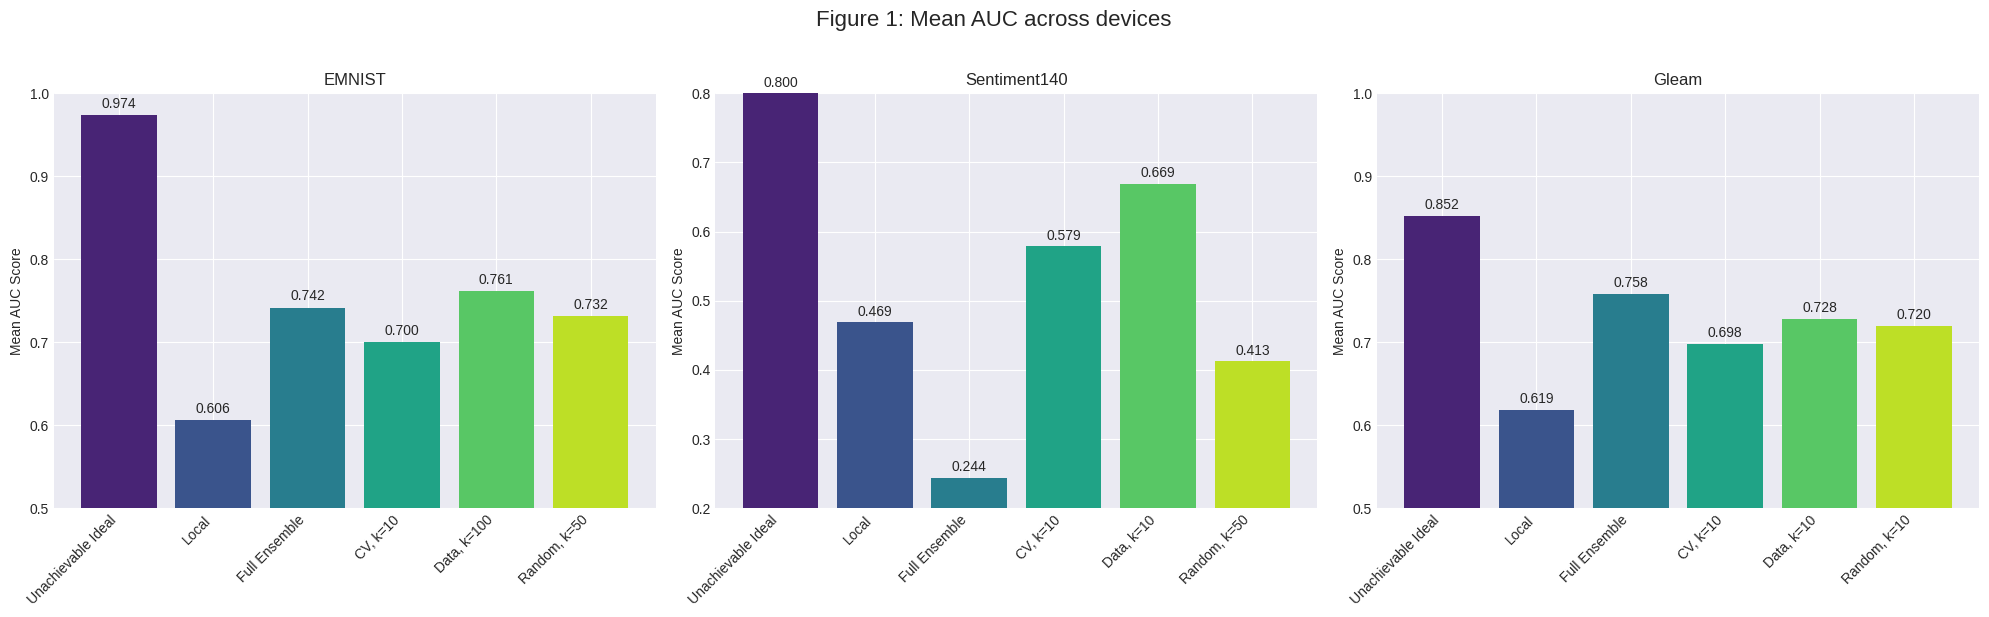


--- Figure 2 (Device Distribution) ---


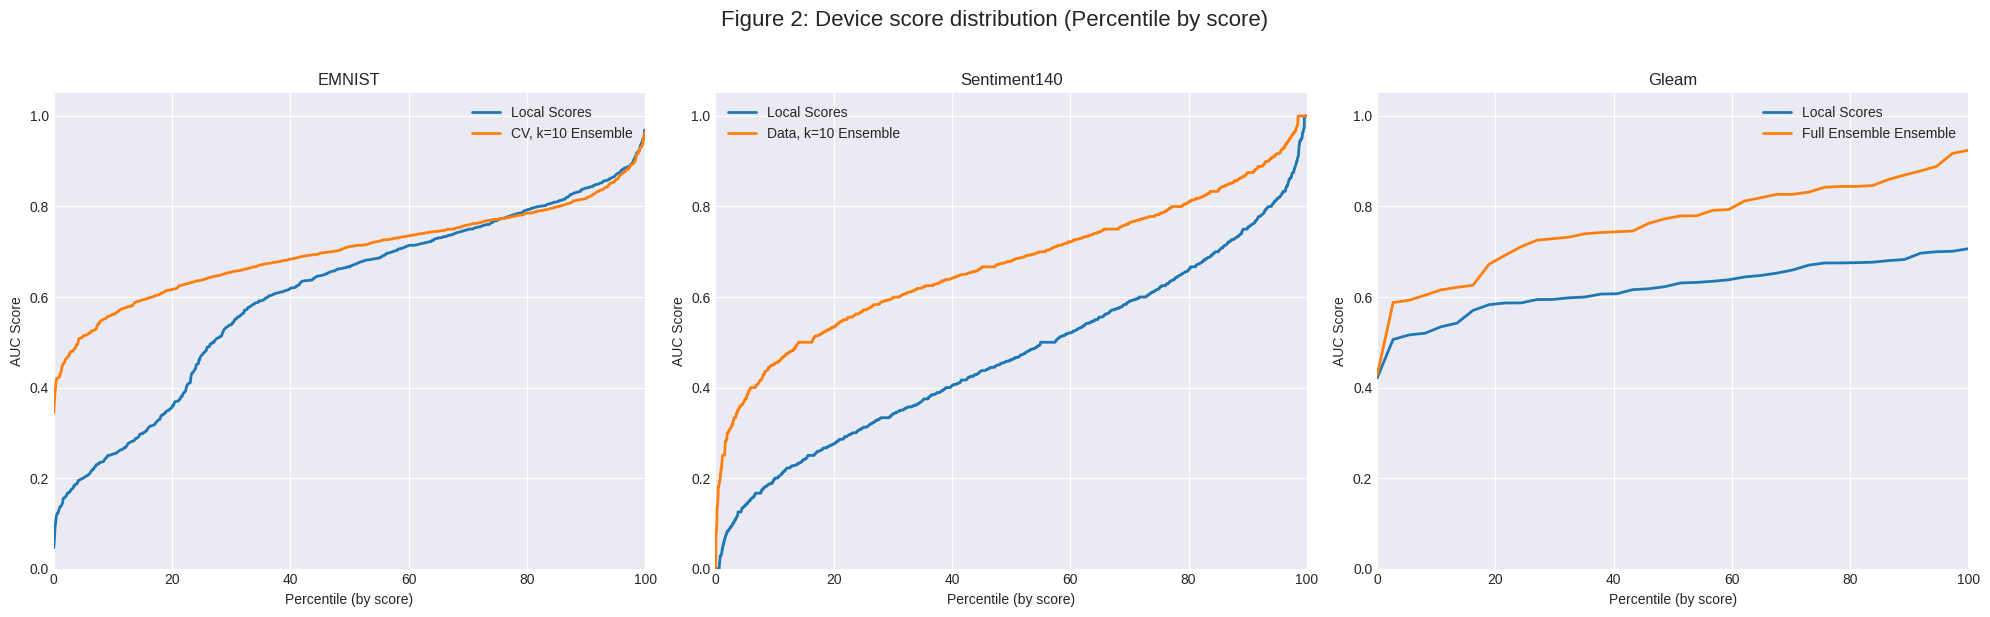


--- Figure 3 (Distillation) ---


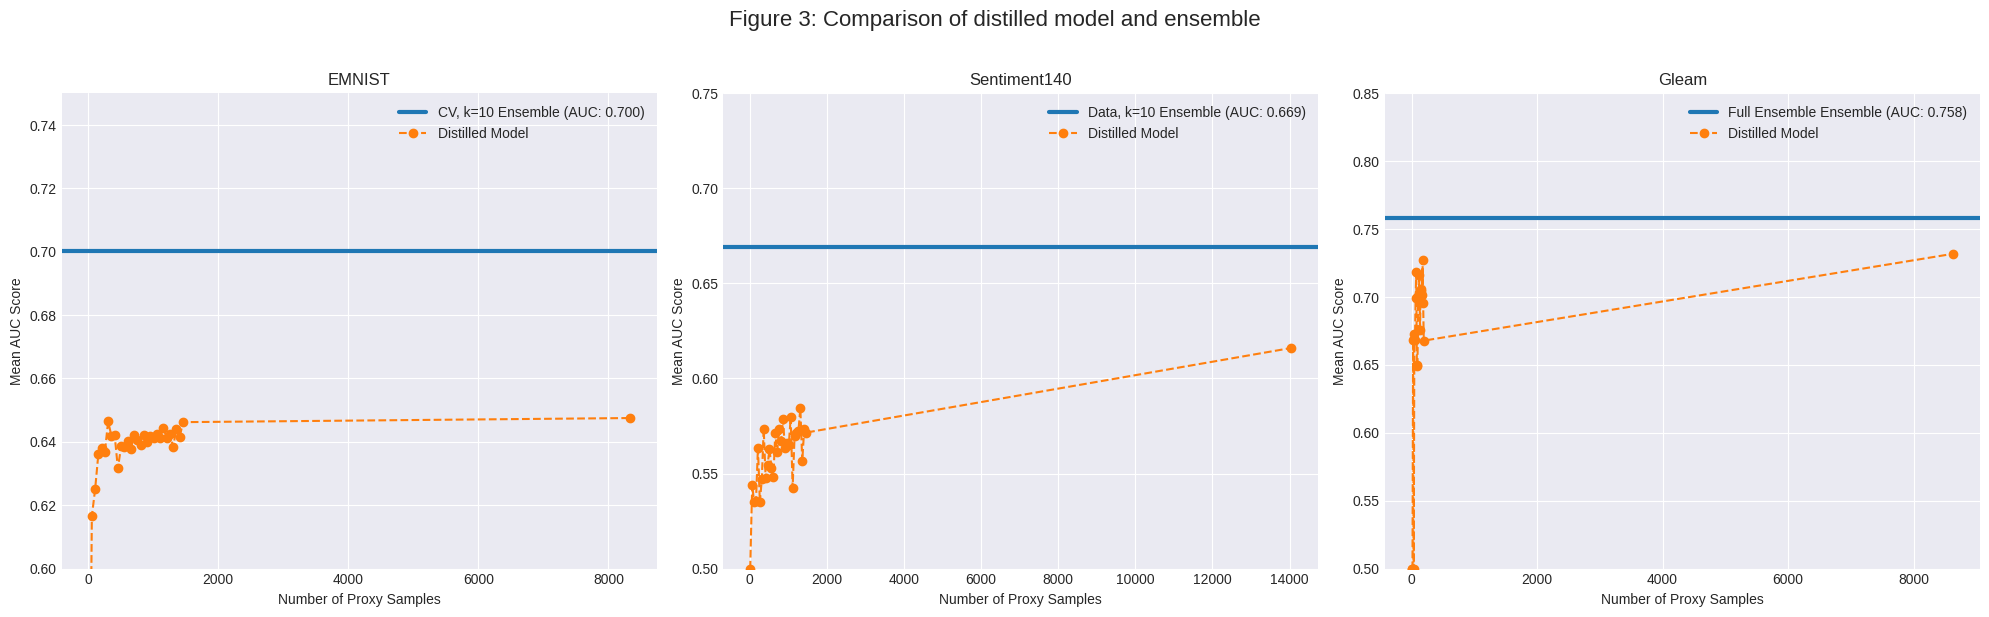


--- Figure 생성 완료 ---


In [12]:
# Google Colab에서 실행하는 것을 전제로 한 코드입니다.
print("--- (셀 10) 모든 Figure 생성 ---")

# 1. 모든 결과 파일 로드
print("저장된 결과(.pkl) 로드 중...")
emnist_results_loaded = load_result('emnist')
sent140_results_loaded = load_result('sent140')
gleam_results_loaded = load_result('gleam')

# 2. Figure 1 출력
print("\n--- Figure 1 (Mean AUC) ---")
plot_figure_1(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded)

# 3. Figure 2 출력
print("\n--- Figure 2 (Device Distribution) ---") # (수정)
plot_figure_2(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded) # (수정)

# 4. Figure 3 출력
print("\n--- Figure 3 (Distillation) ---")
plot_figure_3(emnist_results_loaded, sent140_results_loaded, gleam_results_loaded)

print("\n--- Figure 생성 완료 ---")
